In [1]:
from tensorflow.keras import losses,metrics
import tensorflow as tf
import os
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, concatenate, Conv2D, MaxPooling2D, Conv2DTranspose, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
os.chdir("C:/FIT/Thesis/data/image_chip/data/")

In [2]:
def unet_model(rows, cols, n_band, droprate=0.1):
    inputs = Input((rows, cols, n_band))
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    # conv1 = Dropout(droprate)(conv1)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    pool1 = BatchNormalization()(pool1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Dropout(droprate)(conv2)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    pool2 = BatchNormalization()(pool2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3= Dropout(droprate)(conv3)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    pool3 = BatchNormalization()(pool3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Dropout(droprate)(conv4)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = BatchNormalization()(pool4)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Dropout(droprate)(conv5)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)

    up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
    up6 = BatchNormalization()(up6)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Dropout(droprate)(conv6)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)

    up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
    up7 = BatchNormalization()(up7)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Dropout(droprate)(conv7)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)

    up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    up8 = BatchNormalization()(up8)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Dropout(droprate)(conv8)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)

    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    up9 = BatchNormalization()(up9)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
    # conv9 = Dropout(droprate)(conv9)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

    model = Model(inputs=[inputs], outputs=[conv10])
    model.compile(optimizer=Adam(learning_rate=1e-5), loss = losses.binary_crossentropy, metrics =['binary_accuracy', 'Precision', 'Recall'] )

    return model

In [ ]:
train_x = np.load('./image.npy')
train_y = np.load('./label.npy')
print(train_x.shape)
print(np.max(train_x))

In [4]:
x_train,x_test, y_train, y_test = train_test_split(train_x, train_y, test_size=0.25, random_state=42)
print(x_train.shape)
print(x_test.shape)

(2895, 128, 128, 4)
(965, 128, 128, 4)


In [ ]:
unet = unet_model(128,128,4)
unet.summary()

In [ ]:
model_dir = os.path.join('./models','UNet.h5')
log_dir = os.path.join('./logs','UNet_log')
callback = [
    tf.keras.callbacks.EarlyStopping(patience=3, monitor="val_loss"),
    tf.keras.callbacks.ModelCheckpoint(model_dir, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only = False),
    tf.keras.callbacks.TensorBoard(log_dir=log_dir)
    ]
unet.fit(x_train, y_train, validation_split=0.1, batch_size=32, epochs=30, callbacks= callback)

In [2]:
from tensorflow.keras.models import load_model

model = load_model('./UNet_kmeans.h5', compile=False)
model.compile(optimizer=Adam(learning_rate=1e-5), loss = losses.binary_crossentropy, metrics =['binary_accuracy', 'Precision', 'Recall'])
print("Model is loaded..")

Model is loaded..


In [3]:
test_x = np.load('./x_test.npy')
test_y = np.load('./y_test.npy')

In [12]:
log_dir = os.path.join('./logs/','test')
callback = [
    tf.keras.callbacks.TensorBoard(log_dir=log_dir)
    ]
model.fit(x=test_x, y=test_y, batch_size=16, epochs=30, callbacks=callback)

Epoch 1/30
 1/32 [..............................] - ETA: 7:10 - loss: 0.0408 - binary_accuracy: 0.9829 - precision: 0.8410 - recall: 0.9792

ResourceExhaustedError:  OOM when allocating tensor with shape[16,64,128,128] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node gradient_tape/model/conv2d_16/Conv2D/Conv2DBackpropInput (defined at C:\Users\mazed\AppData\Local\Temp/ipykernel_16900/900606879.py:5) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_6691]

Function call stack:
train_function


In [7]:
print(log_dir)

./logs/test


In [3]:
import cv2
from scipy import ndimage as ndi
from skimage import measure, filters
from skimage.segmentation import watershed
from skimage.feature import peak_local_max

def Gaussian_filter(image, sigma =1):
    img=np.copy(image)
    blur = filters.gaussian(img, sigma=sigma)
    return blur

def Find_threshold_otsu(image):
    t = filters.threshold_otsu(image)
    return t

def Binary(image, threshold, max_value = 1):
    img=np.copy(image)
    (t,masklayer)=cv2.threshold(img,threshold,max_value,cv2.THRESH_BINARY)
    return masklayer

def ExtractObjects(image):
    img=np.copy(image)
    blob_labels=measure.label(img,background=0)
    number_of_objects=np.unique(blob_labels)
    return blob_labels,number_of_objects

In [7]:
x_test = np.load("./x_test.npy")
y_test = np.load("./y_test.npy")
y_pred = model.predict(x_test)

In [4]:
from skimage.feature import blob_log
from math import sqrt
import random as rd
import earthpy.plot as ep
i = rd.randint(0,len(x_test))
res = y_pred[i,:,:]
blur = Gaussian_filter(res, sigma=1)
t = Find_threshold_otsu(res)
res = Binary(blur,t)

# blobs_dog = blob_dog(blur, min_sigma=0.5, max_sigma=3, threshold=.05, overlap=.2)
# blobs_dog[:, 2] = blobs_dog[:, 2] * sqrt(2)
blobs_log = blob_log(res, min_sigma=1, max_sigma=3, num_sigma=10, threshold=.05, overlap=.2)
blobs_log[:, 2] = blobs_log[:, 2] * sqrt(2)

fig, ax = plt.subplots(ncols=3, nrows=1, figsize=(25, 25))
band_indices = [3, 2, 1]
ep.plot_rgb(x_test[i,:,:,:].transpose([2,0,1]),
                rgb=band_indices,
                title="Satellite Image",
                stretch=True,
                ax=ax[0])
ax[1].imshow(y_test[i,:,:].squeeze(), cmap='binary')
ax[1].set_title("Ground Truth")
for blob in blobs_log:
    y, x, r = blob
    c = plt.Circle((x, y), r+1, color='red', linewidth=2, fill=False)
    ax[2].add_patch(c)
ax[2].imshow(res.squeeze(), cmap='binary')
ax[2].set_title("Prediction & no. of trees: "+str(len(blobs_log)))
plt.show()

blob_labels,number_of_objects = ExtractObjects(res)
# res = (y_pred[i,:,:] > 0.2).astype(np.uint8)
fig, ax = plt.subplots(ncols=3, nrows=1, figsize=(23, 23))
band_indices = [3, 2, 1]
ep.plot_rgb(x_test[i,:,:,:].transpose([2,0,1]),
                rgb=band_indices,
                title="Satellite Image",
                stretch=True,
                ax=ax[0])
ax[1].imshow(y_test[i,:,:].squeeze(), cmap='binary')
ax[1].set_title("Ground Truth")
ax[2].imshow(blob_labels, cmap='gist_ncar')
ax[2].set_title("Prediction & no. of trees: {}".format(number_of_objects[-1]))
plt.show()

NameError: name 'x_test' is not defined

In [5]:
import random as rd
import earthpy.plot as ep
i = rd.randint(0,len(x_test))
print(i)
res = y_pred[i,:,:]
# blur = Gaussian_filter(res, sigma=1)
# t = Find_threshold_otsu(res)
# res = Binary(blur,t)
# blob_labels,number_of_objects = ExtractObjects(res)
# res = (y_pred[i,:,:] > 0.2).astype(np.uint8)
fig, ax = plt.subplots(ncols=3, nrows=1, figsize=(23, 23))
band_indices = [3, 2, 1]
ep.plot_rgb(x_test[i,:,:,:].transpose([2,0,1]),
                rgb=band_indices,
                title="Satellite Image (False color composite)",
                stretch=True,
                ax=ax[0])
ax[1].imshow(y_test[i,:,:].squeeze(), cmap='binary')
ax[1].set_title("Ground Truth")
ax[2].imshow(res.squeeze(), cmap='binary')
ax[2].set_title("Prediction")
# ax[3].imshow(blob_labels, cmap='gist_ncar')
# ax[3].set_title("Number of Trees: {}".format(number_of_objects[-1]))
plt.show()
# plt.imshow(y_pred[60,:,:], cmap='binary')

NameError: name 'x_test' is not defined

In [7]:
import rasterio as rs
img = rs.open("images/clip1.tif")
imgArr = img.read([1,2,3,4])
imgArr = np.moveaxis(imgArr, 0, -1)
from patchify import patchify,unpatchify
images = patchify(imgArr,(128,128,4),128)
images = images[:,:,0,:,:,:]


In [8]:
import earthpy.plot as ep
list = []
for i in range(images.shape[0]):
        for j in range(images.shape[1]):
            image = images[i,j,:,:,:]
            patch_img = np.expand_dims(image, axis=0)
            pred = model.predict(patch_img)
            list.append(pred)
pred_i = np.array(list)

patched_prediction = np.reshape(pred_i, [images.shape[0], images.shape[1], images.shape[2], images.shape[3]])
unpatched_prediction = unpatchify(patched_prediction, (imgArr.shape[0], imgArr.shape[1]))

In [14]:
with rs.open("result_1.tif","w",driver='GTiff', count=1, dtype=rs.uint16,
                         width=imgArr.shape[0], height=imgArr.shape[1], transform=img.transform, crs=img.crs) as raschip:
                         raschip.write(res,1)

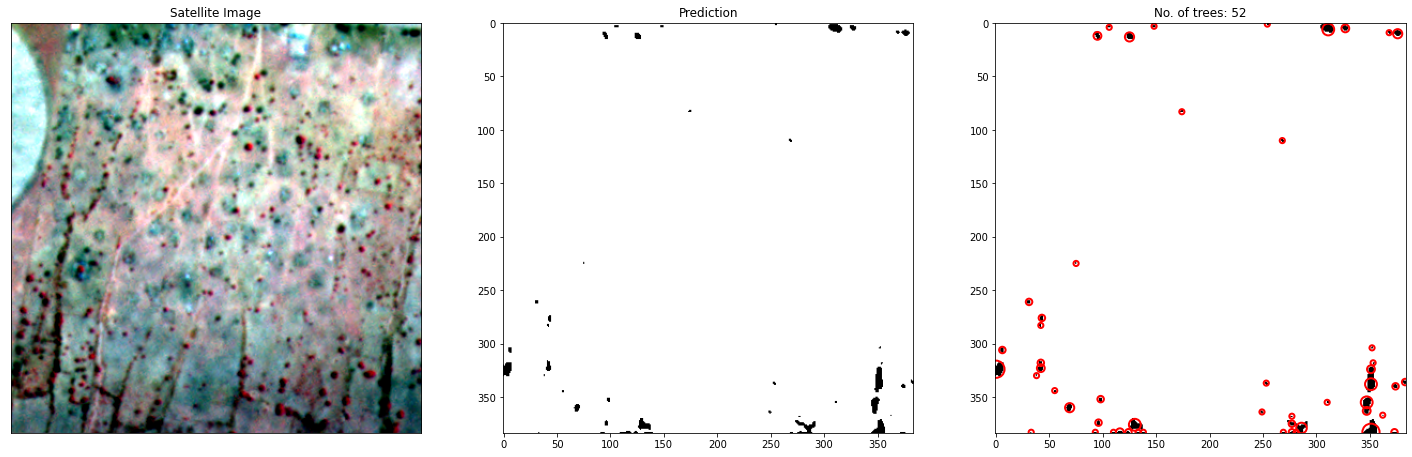

In [39]:
res = unpatched_prediction
blur = Gaussian_filter(res, sigma=1)
t = Find_threshold_otsu(res)
res = Binary(blur,t)
blobs_log = blob_log(res, min_sigma=1, max_sigma=5, num_sigma=10, threshold=.2, overlap=.01)
blobs_log[:, 2] = blobs_log[:, 2] * sqrt(2)

fig, ax = plt.subplots(ncols=3, nrows=1, figsize=(25, 25))
band_indices = [3, 2, 1]
ep.plot_rgb(imgArr.transpose([2,0,1]),
                rgb=band_indices,
                title="Satellite Image",
                stretch=True,
                ax=ax[0])
ax[1].imshow(res, cmap='binary')
ax[1].set_title("Prediction")
lon = []
lat = []
val = []
for blob in blobs_log:
    y, x, r = blob
    transform = None
    c = plt.Circle((x, y), r+1, color='red', linewidth=2, fill=False)
    y1, x1 = rs.transform.xy(transform = img.transform, rows =y, cols=x)
    lon.append(x1)
    lat.append(y1)
    val.append(r)
    ax[2].add_patch(c)
ax[2].imshow(res.squeeze(), cmap='binary')
ax[2].set_title("No. of trees: "+str(len(blobs_log)))
plt.show()

In [15]:
img = rs.open("images/clip1.tif")
img.crs

CRS.from_wkt('PROJCS["WGS 84 / UTM zone 34S",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",21],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",10000000],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32734"]]')

In [40]:
import fiona
from osgeo import osr
from fiona.crs import from_epsg
from shapely.geometry import Point,mapping

point_df = np.column_stack([np.array(lat), np.array(lon), np.array(val)])
schema = {
    'geometry':'Point',
    'properties':{'id': 'int','Value':'float:15.2'}
}

srs = osr.SpatialReference()
srs.ImportFromEPSG(32734)
epsg = srs.ExportToProj4()

with fiona.open("trees_1.geojson", 'w', crs=epsg, driver="GeoJSON", schema=schema) as sink:
    for i in range(len(point_df)):
        point = Point(point_df[i,:2])
        sink.write({
            'geometry': mapping(point),
            'properties': {'id': i+1, 'Value': point_df[i,2]},
        })